### Plot comparison curves based on cross validation

In [1]:
import json
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size+1)]

def plot_training_logs(log_file_1, log_file_2, label, figure_name, epochs=400):
    # Load JSON logs
    logs_1 = []
    logs_2 = []
    with open(log_file_1, 'r') as f:
        logs_1 = [json.loads(line) for line in f]
    with open(log_file_2, 'r') as f:
        logs_2 = [json.loads(line) for line in f]
    
    # Prepare data arrays
    epoch_nums_full = [log['epoch'] for log in logs_1][:epochs]
    epoch_nums = epoch_nums_full[1:epochs:2]  # Only odd epochs for validation metrics
    
    train_loss_1 = [log.get('train/loss', None) for log in logs_1][:epochs]
    val_loss_1 = [log.get('val/loss', None) for log in logs_1][1:epochs:2]
    train_loss_2 = [log.get('train/loss', None) for log in logs_2][:epochs]
    val_loss_2 = [log.get('val/loss', None) for log in logs_2][1:epochs:2]

    val_dice_kidney_1 = [log.get('val/dice_kidney', None) for log in logs_1][1:epochs:2]
    val_dice_tumor_1 = [log.get('val/dice_tumor', None) for log in logs_1][1:epochs:2]
    val_dice_kidney_2 = [log.get('val/dice_kidney', None) for log in logs_2][1:epochs:2]
    val_dice_tumor_2 = [log.get('val/dice_tumor', None) for log in logs_2][1:epochs:2]

    # Compute moving averages for dice scores
    val_dice_kidney_1_ma = moving_average(val_dice_kidney_1, 5)
    val_dice_tumor_1_ma = moving_average(val_dice_tumor_1, 5)
    val_dice_kidney_2_ma = moving_average(val_dice_kidney_2, 5)
    val_dice_tumor_2_ma = moving_average(val_dice_tumor_2, 5)

    # Plotting
    plt.figure(figsize=(18, 12))

    plt.subplot(321)
    plt.plot(epoch_nums_full, train_loss_1, label=f'Train Loss ({label[0]})')
    plt.plot(epoch_nums_full, train_loss_2, label=f'Train Loss ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss Comparison')
    plt.legend()

    plt.subplot(322)
    plt.plot(epoch_nums, val_loss_1, label=f'Validation Loss ({label[0]})')
    plt.plot(epoch_nums, val_loss_2, label=f'Validation Loss ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()

    plt.subplot(323)
    plt.plot(epoch_nums, val_dice_kidney_1, label=f'Kidney Dice ({label[0]})')
    plt.plot(epoch_nums, val_dice_kidney_2, label=f'Kidney Dice ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Kidney Dice Coefficient')
    plt.legend()

    plt.subplot(324)
    plt.plot(epoch_nums[:len(val_dice_kidney_1_ma)], val_dice_kidney_1_ma, linestyle='--', label=f'MA Kidney Dice ({label[0]})')
    plt.plot(epoch_nums[:len(val_dice_kidney_2_ma)], val_dice_kidney_2_ma, linestyle='--', label=f'MA Kidney Dice ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Moving Average Kidney Dice')
    plt.legend()

    plt.subplot(325)
    plt.plot(epoch_nums, val_dice_tumor_1, label=f'Tumor Dice ({label[0]})')
    plt.plot(epoch_nums, val_dice_tumor_2, label=f'Tumor Dice ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Tumor Dice Coefficient')
    plt.legend()

    plt.subplot(326)
    plt.plot(epoch_nums[:len(val_dice_tumor_1_ma)], val_dice_tumor_1_ma, linestyle='--', label=f'MA Tumor Dice ({label[0]})')
    plt.plot(epoch_nums[:len(val_dice_tumor_2_ma)], val_dice_tumor_2_ma, linestyle='--', label=f'MA Tumor Dice ({label[1]})')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title('Moving Average Tumor')
    plt.legend()

    plt.tight_layout()
    plt.savefig(figure_name)
    plt.show()

In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size):
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size+1)]

def load_metrics(log_path_pattern, metric_key, epochs, fold_count=5, validation_interval=2):
    """ Load metric data from multiple log files and compute the average across folds. """
    fold_metrics = []
    for i in range(0, fold_count):
        log_file = log_path_pattern.format(i=i)
        with open(log_file, 'r') as f:
            logs = [json.loads(line) for line in f]
        metrics = [log.get(metric_key, None) for log in logs if log.get(metric_key) is not None][:epochs]
        if len(metrics) < epochs:  # Fill missing data if necessary
            full_metrics = [None] * epochs
            indices = list(range(0, epochs, validation_interval))
            for idx, val in zip(indices, metrics):
                full_metrics[idx] = val
            metrics = full_metrics
        fold_metrics.append(metrics)
    # Average across all folds, ignoring None values
    return np.nanmean(np.where(fold_metrics, fold_metrics, np.nan), axis=0)

def plot_average_training_logs(log_path_pattern_1, log_path_pattern_2, label, figure_name, epochs=400, fold_count=5, validation_interval=2):
    # Load and average metrics
    train_loss_1 = load_metrics(log_path_pattern_1, 'train/loss', epochs, fold_count)
    val_loss_1 = load_metrics(log_path_pattern_1, 'val/loss', epochs, fold_count, validation_interval)
    train_loss_2 = load_metrics(log_path_pattern_2, 'train/loss', epochs, fold_count)
    val_loss_2 = load_metrics(log_path_pattern_2, 'val/loss', epochs, fold_count, validation_interval)

    val_dice_kidney_1 = load_metrics(log_path_pattern_1, 'val/dice_kidney', epochs, fold_count, validation_interval)
    val_dice_tumor_1 = load_metrics(log_path_pattern_1, 'val/dice_tumor', epochs, fold_count, validation_interval)
    val_dice_kidney_2 = load_metrics(log_path_pattern_2, 'val/dice_kidney', epochs, fold_count, validation_interval)
    val_dice_tumor_2 = load_metrics(log_path_pattern_2, 'val/dice_tumor', epochs, fold_count, validation_interval)

    epoch_nums = list(range(epochs))

    # Compute moving averages
    val_dice_kidney_1_ma = moving_average(val_dice_kidney_1, 5)
    val_dice_tumor_1_ma = moving_average(val_dice_tumor_1, 5)
    val_dice_kidney_2_ma = moving_average(val_dice_kidney_2, 5)
    val_dice_tumor_2_ma = moving_average(val_dice_tumor_2, 5)

    # Plotting
    plt.figure(figsize=(18, 12))

    # Train Loss
    plt.subplot(321)
    plt.plot(epoch_nums, train_loss_1, label=f'Train Loss ({label[0]})')
    plt.plot(epoch_nums, train_loss_2, label=f'Train Loss ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Train Loss')
    plt.title('Average Train Loss Comparison')
    plt.legend()

    # Validation Loss
    plt.subplot(322)
    plt.plot(epoch_nums, val_loss_1, label=f'Validation Loss ({label[0]})')
    plt.plot(epoch_nums, val_loss_2, label=f'Validation Loss ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Validation Loss')
    plt.title('Average Validation Loss Comparison')
    plt.legend()

    # Kidney Dice Coefficient
    plt.subplot(323)
    plt.plot(epoch_nums, val_dice_kidney_1, label=f'Kidney Dice ({label[0]})')
    plt.plot(epoch_nums, val_dice_kidney_2, label=f'Kidney Dice ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Dice Coefficient')
    plt.title('Average Kidney Dice Coefficient')
    plt.legend()

    # Moving Average Kidney Dice
    plt.subplot(324)
    plt.plot(epoch_nums[:len(val_dice_kidney_1_ma)], val_dice_kidney_1_ma, linestyle='--', label=f'MA Kidney Dice ({label[0]})')
    plt.plot(epoch_nums[:len(val_dice_kidney_2_ma)], val_dice_kidney_2_ma, linestyle='--', label=f'MA Kidney Dice ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Dice Coefficient')
    plt.title('Average Moving Average Kidney Dice')
    plt.legend()

    # Tumor Dice Coefficient
    plt.subplot(325)
    plt.plot(epoch_nums, val_dice_tumor_1, label=f'Tumor Dice ({label[0]})')
    plt.plot(epoch_nums, val_dice_tumor_2, label=f'Tumor Dice ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Dice Coefficient')
    plt.title('Average Tumor Dice Coefficient')
    plt.legend()

    # Moving Average Tumor
    plt.subplot(326)
    plt.plot(epoch_nums[:len(val_dice_tumor_1_ma)], val_dice_tumor_1_ma, linestyle='--', label=f'MA Tumor Dice ({label[0]})')
    plt.plot(epoch_nums[:len(val_dice_tumor_2_ma)], val_dice_tumor_2_ma, linestyle='--', label=f'MA Tumor Dice ({label[1]})')
    plt.xlabel('Epoch/2')
    plt.ylabel('Dice Coefficient')
    plt.title('Average Moving Average Tumor Dice')
    plt.legend()

    plt.tight_layout()
    plt.savefig(figure_name)
    plt.show()


### Compare Different Number of Batches

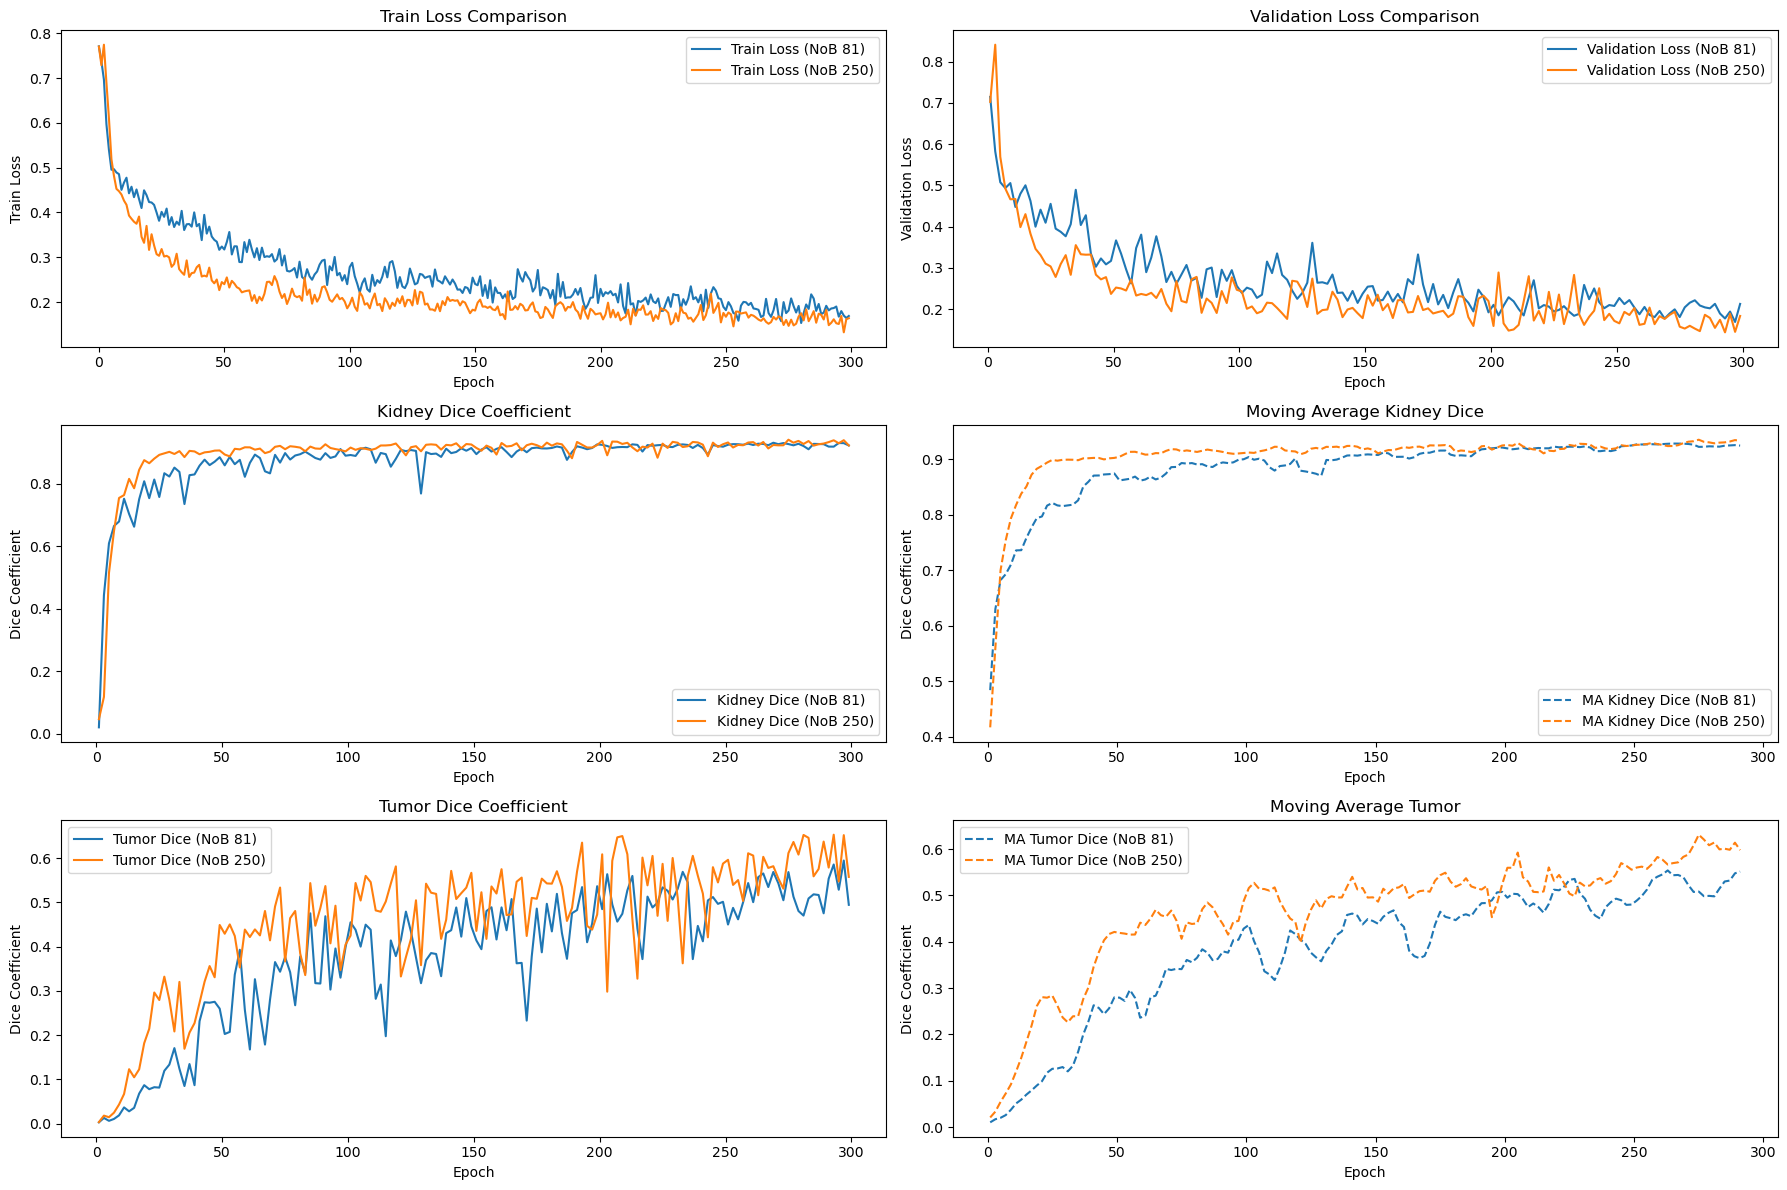

In [19]:
log_file_81 = 'outputs_1/training_logs.json'
log_file_250 = 'outputs_2/training_logs.json'
fig_name = 'plots/Different_Number_of_Batches.png'
label = ['NoB 81', 'NoB 250']
plot_training_logs(log_file_81, log_file_250, label, fig_name, epochs=300)

### Different Optimizers

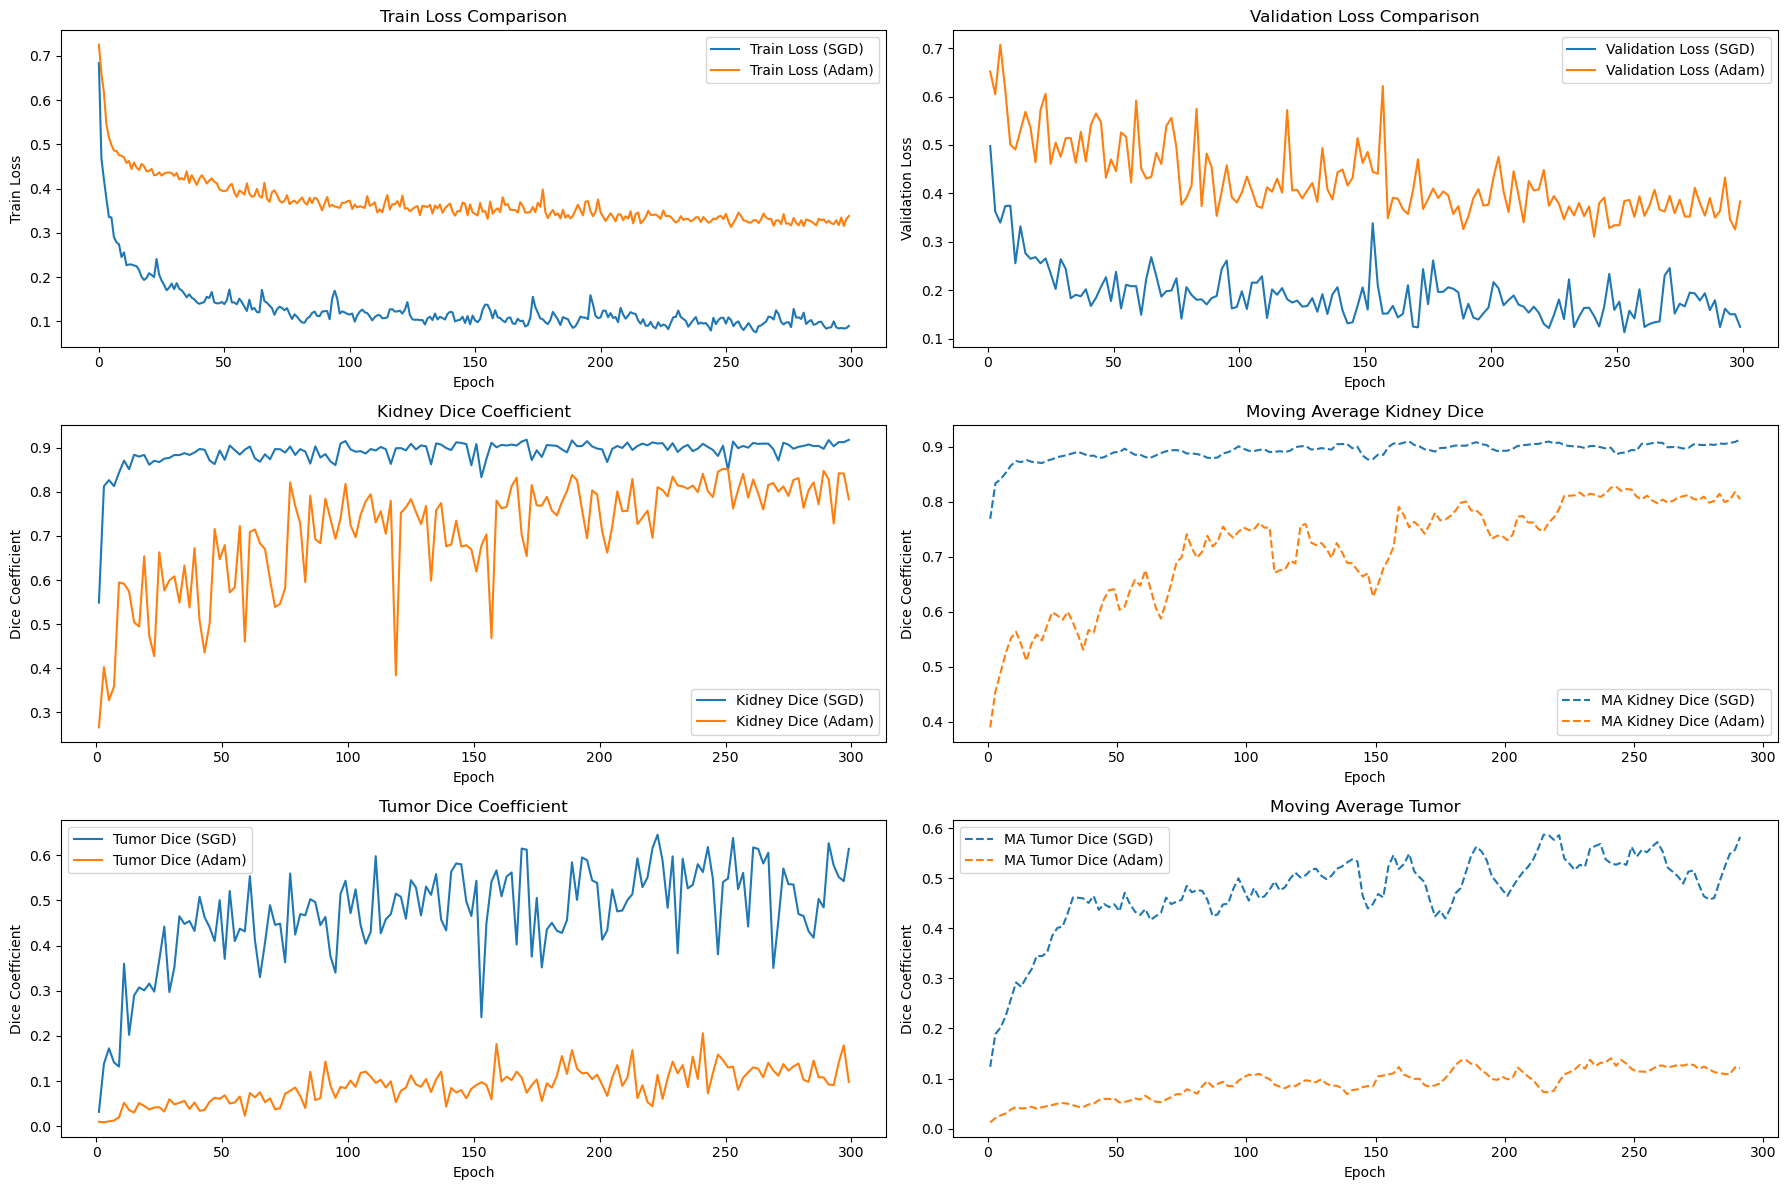

In [3]:
log_file_sgd = 'outputs_15_plane_unet_3d_fold0_epochs1000/training_logs.json'
log_file_adam = 'outputs_17_plane_unet_3d_fold0_epochs1000_adam_0.05/training_logs.json'
fig_name = 'plots/Different_Optimizer.png'

plot_training_logs(log_file_sgd, log_file_adam, ['SGD', 'Adam'], fig_name, epochs=300)

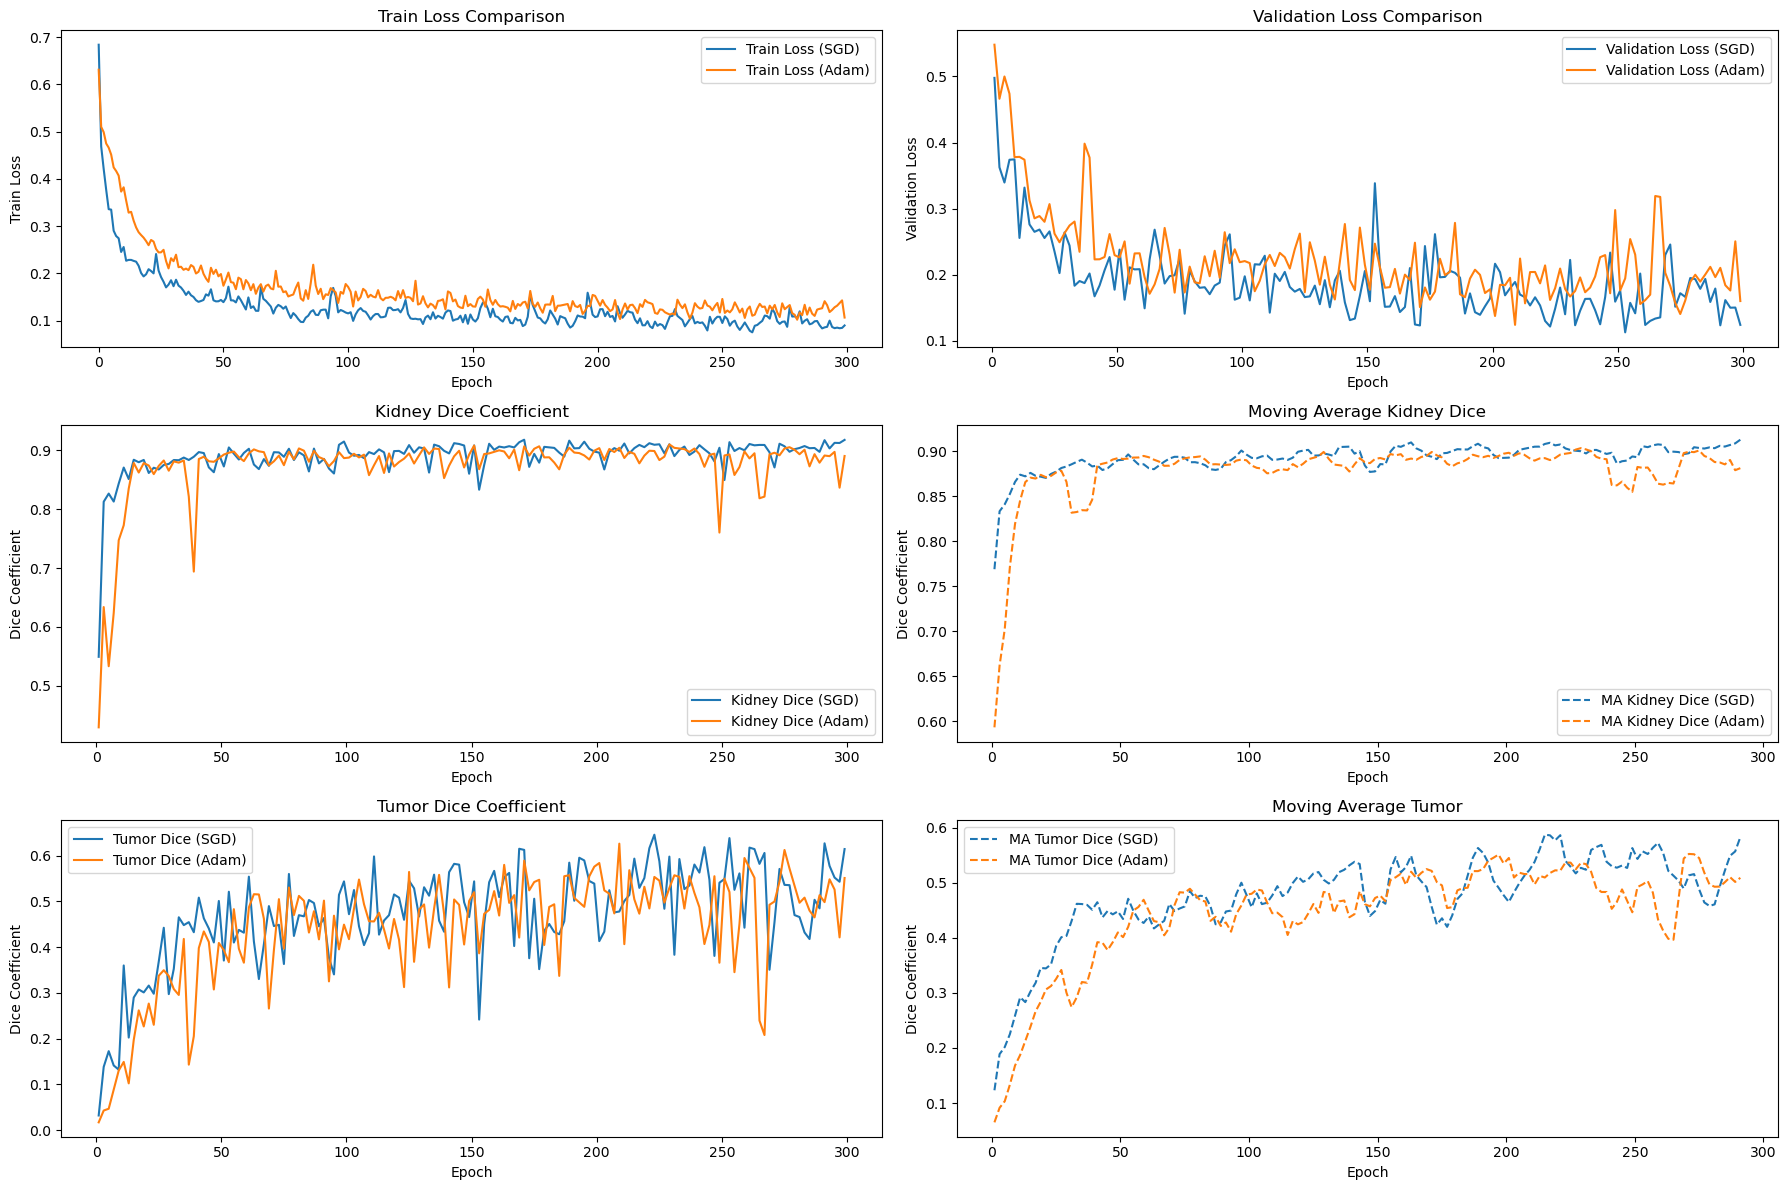

In [29]:
log_file_sgd = 'outputs_15_plane_unet_3d_fold0_epochs1000/training_logs.json'
log_file_adam = 'outputs_20_plane_unet_3d_fold0_epochs1000_adam_0.005/training_logs.json'
fig_name = 'plots/Different_Optimizer_Best_Adam.png'

plot_training_logs(log_file_sgd, log_file_adam, ['SGD', 'Adam'], fig_name, epochs=300)

### Foreground

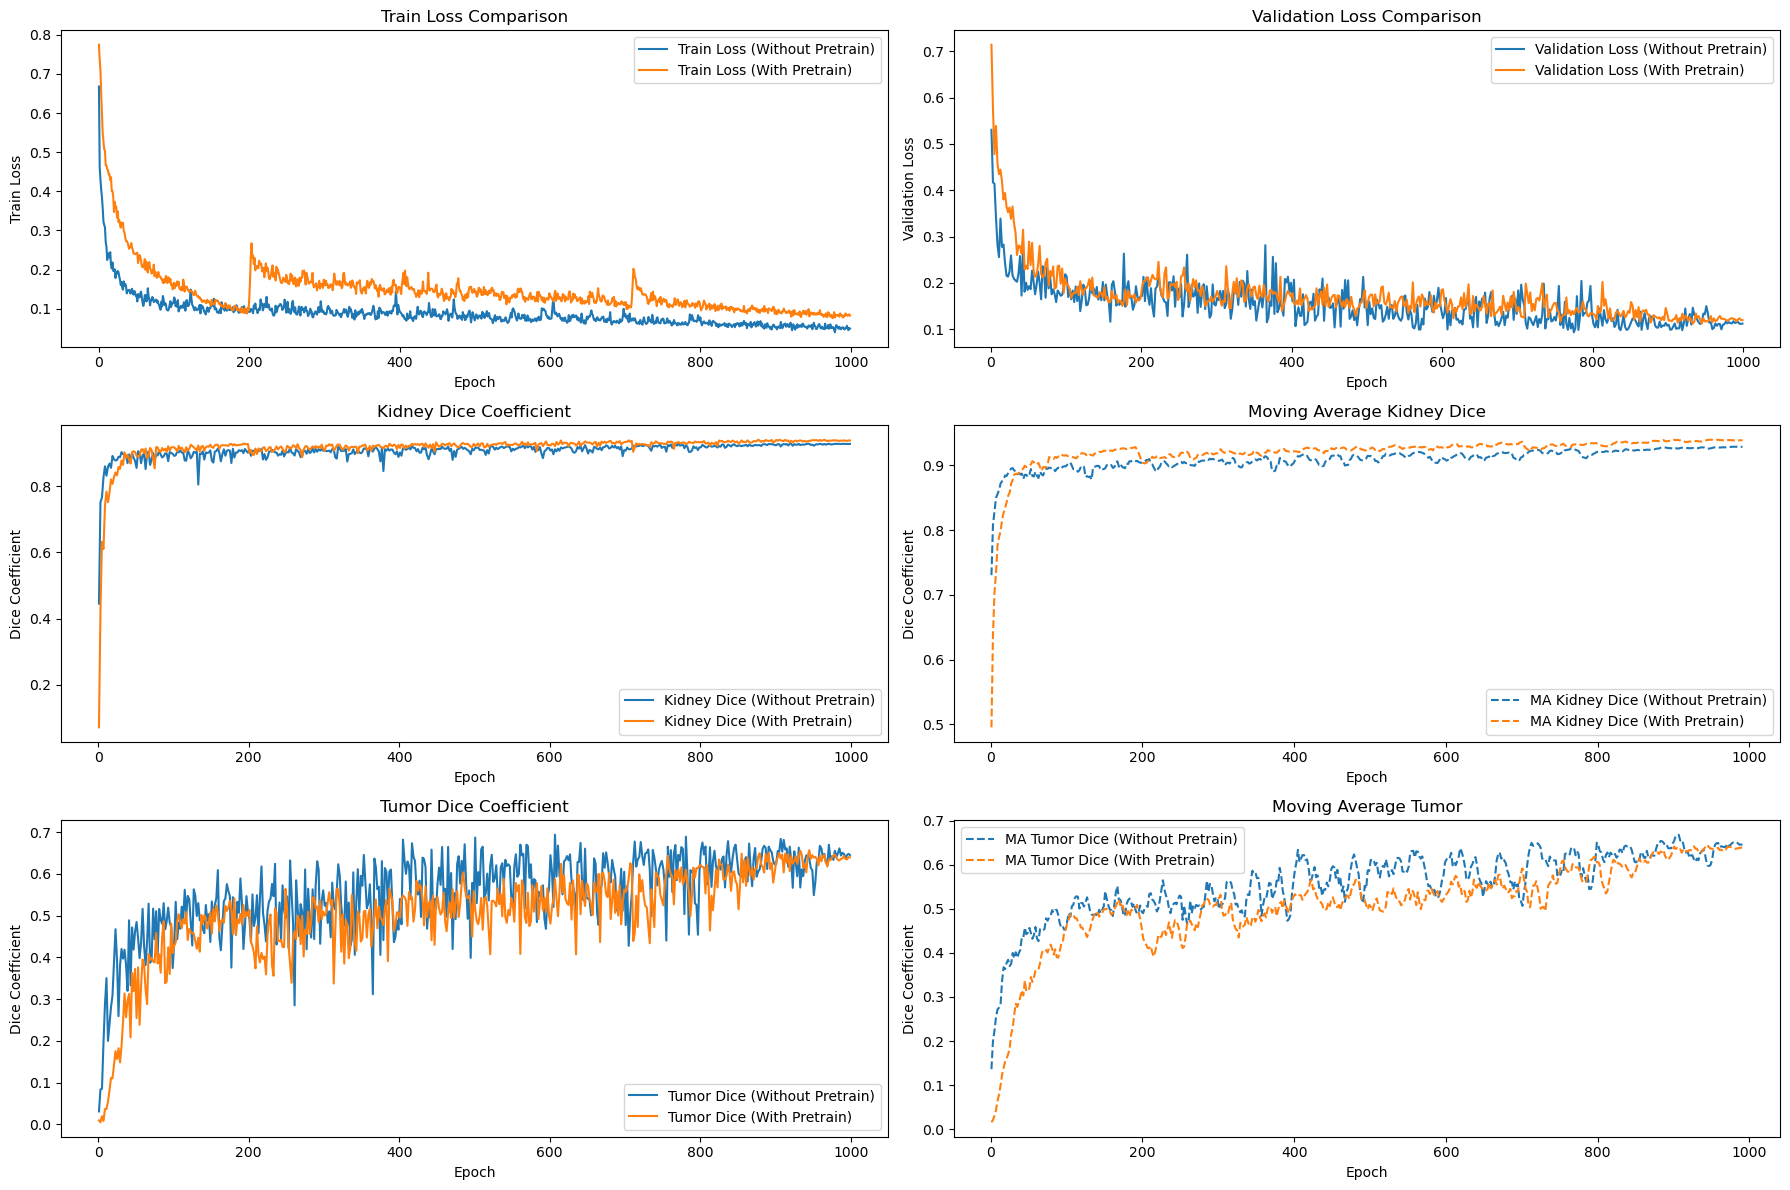

In [6]:
log_file = 'outputs_14_residual_unet_3d_fold0_epochs1000/training_logs.json'
log_file_pretrain = 'residual_unet_3d_fold0_epochs1000_with_pretrain/training_logs.json'

fig_name = 'plots/Residue_Pretrain.png'

plot_training_logs(log_file, log_file_pretrain, ['Without Pretrain', 'With Pretrain'], fig_name, epochs=1000)

### Pretrain Comparison

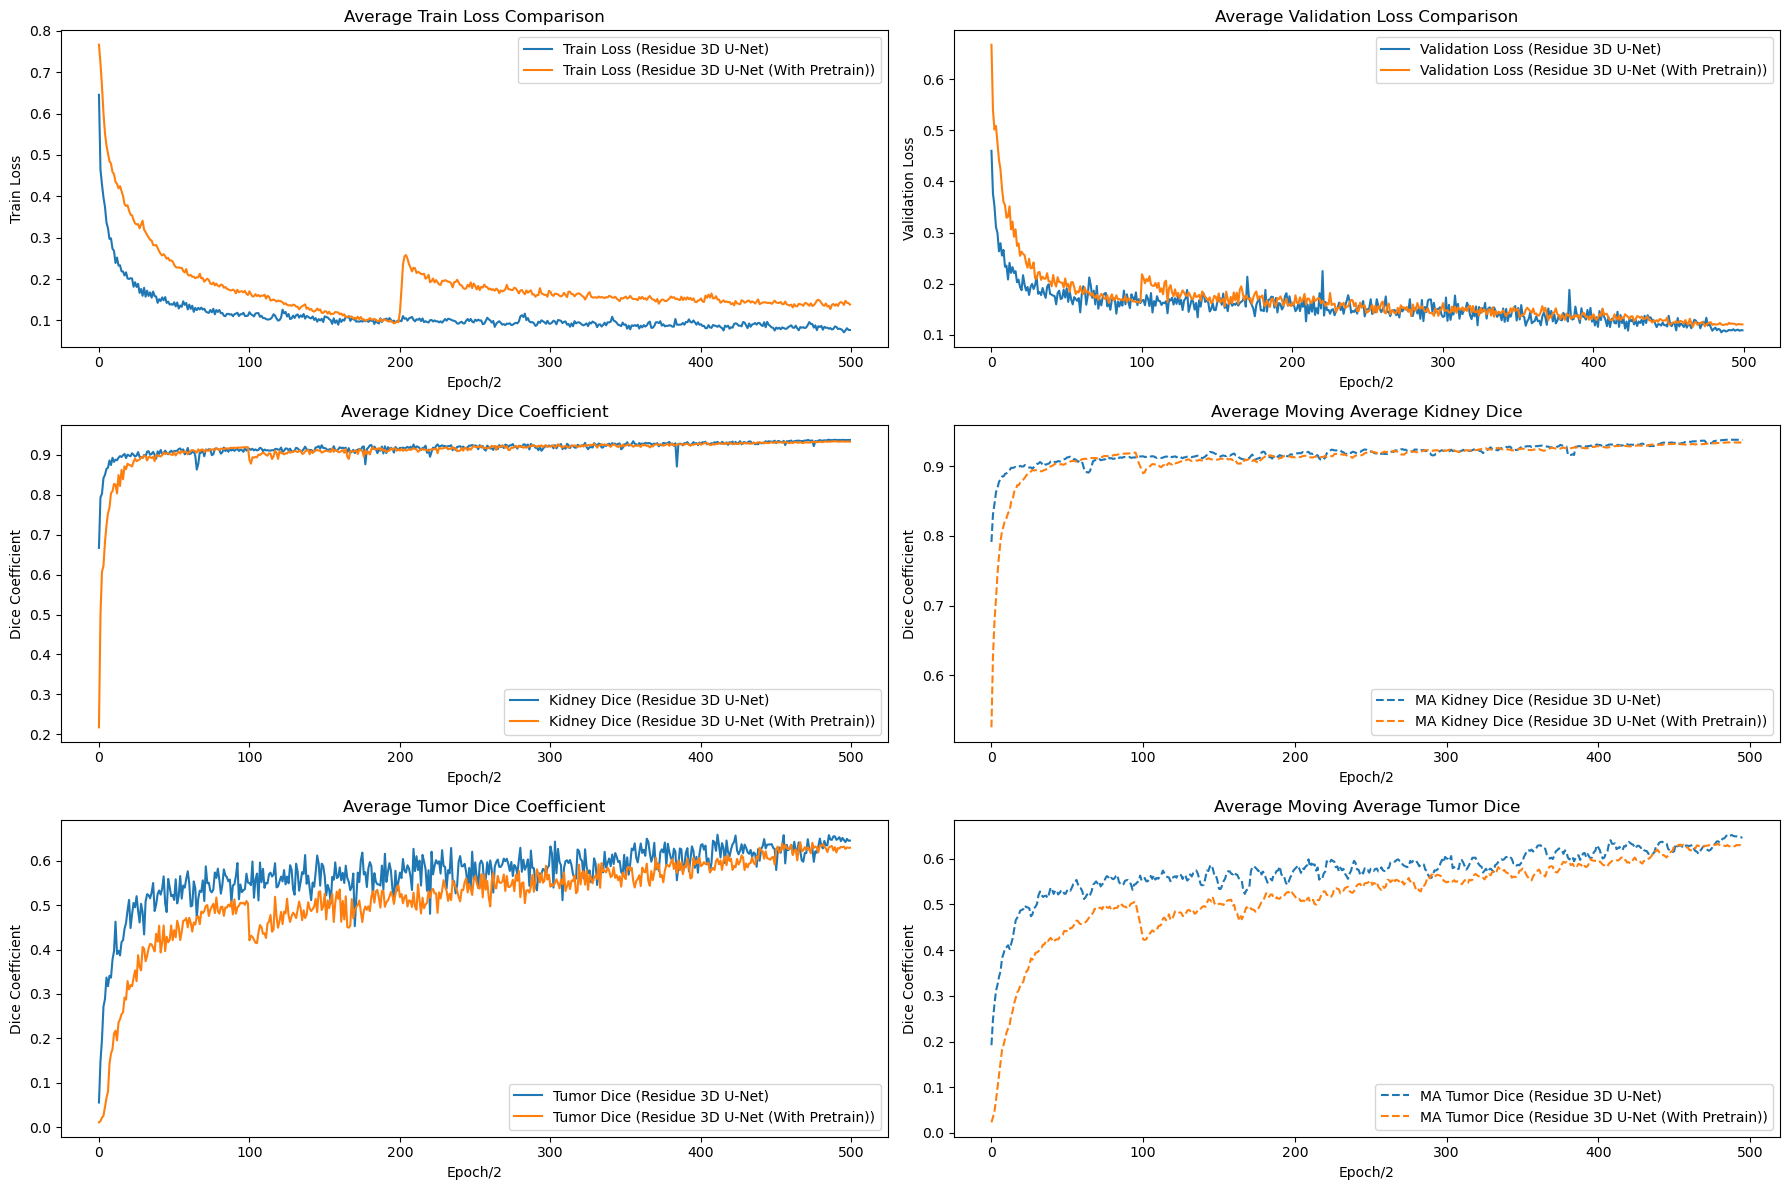

In [24]:
plot_average_training_logs(
    log_path_pattern_1='residual_unet_3d_fold{i}_epochs1000/training_logs.json',
    log_path_pattern_2='residual_unet_3d_fold{i}_epochs1000_with_pretrain/training_logs.json',
    label=['Residue 3D U-Net', 'Residue 3D U-Net (With Pretrain)'],
    figure_name='plots/residue_pretrainaverage_training_comparison.png',
    epochs=500
)

### Residue v.s. Plain

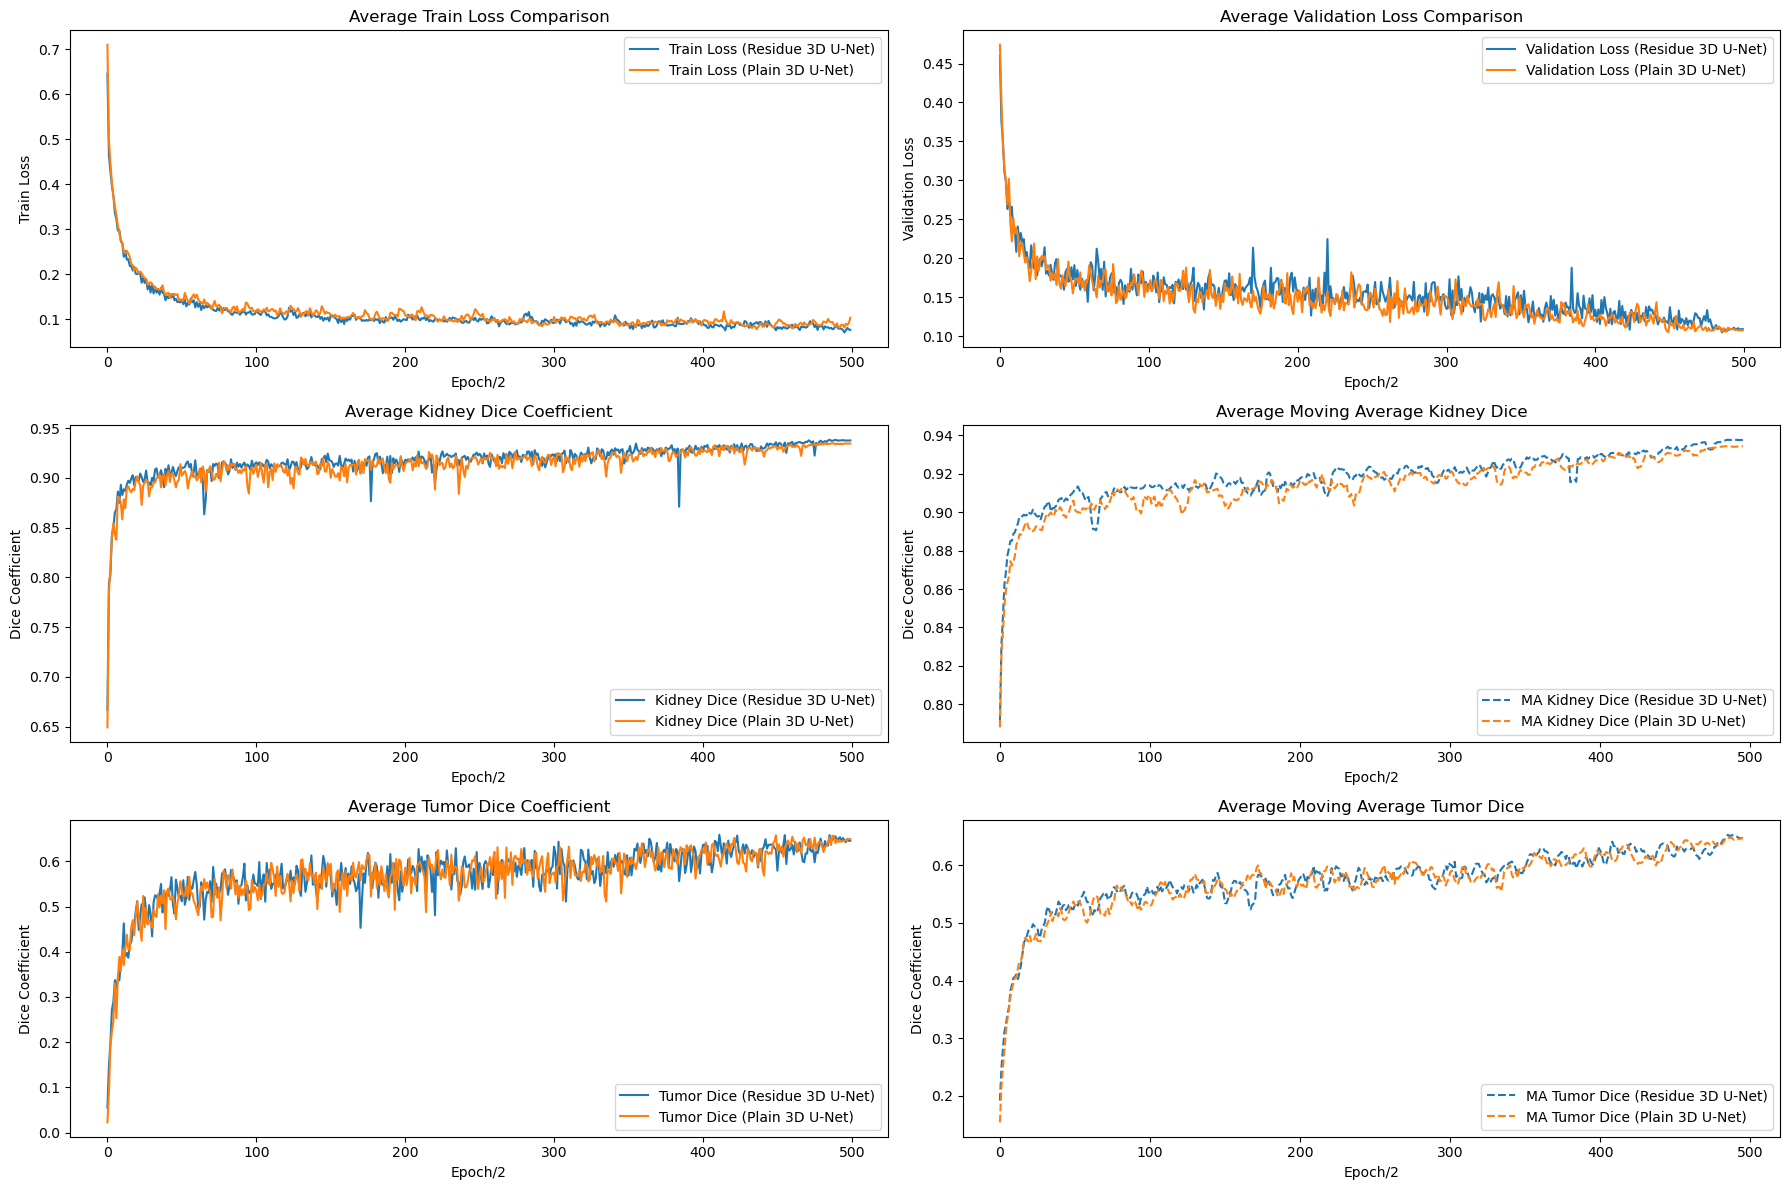

In [27]:
plot_average_training_logs(
    log_path_pattern_1='residual_unet_3d_fold{i}_epochs1000/training_logs.json',
    log_path_pattern_2='plane_unet_3d_fold{i}_epochs1000/training_logs.json',
    label=['Residue 3D U-Net', 'Plain 3D U-Net'],
    figure_name='plots/residue_plain_average_training_comparison.png',
    epochs=500
)

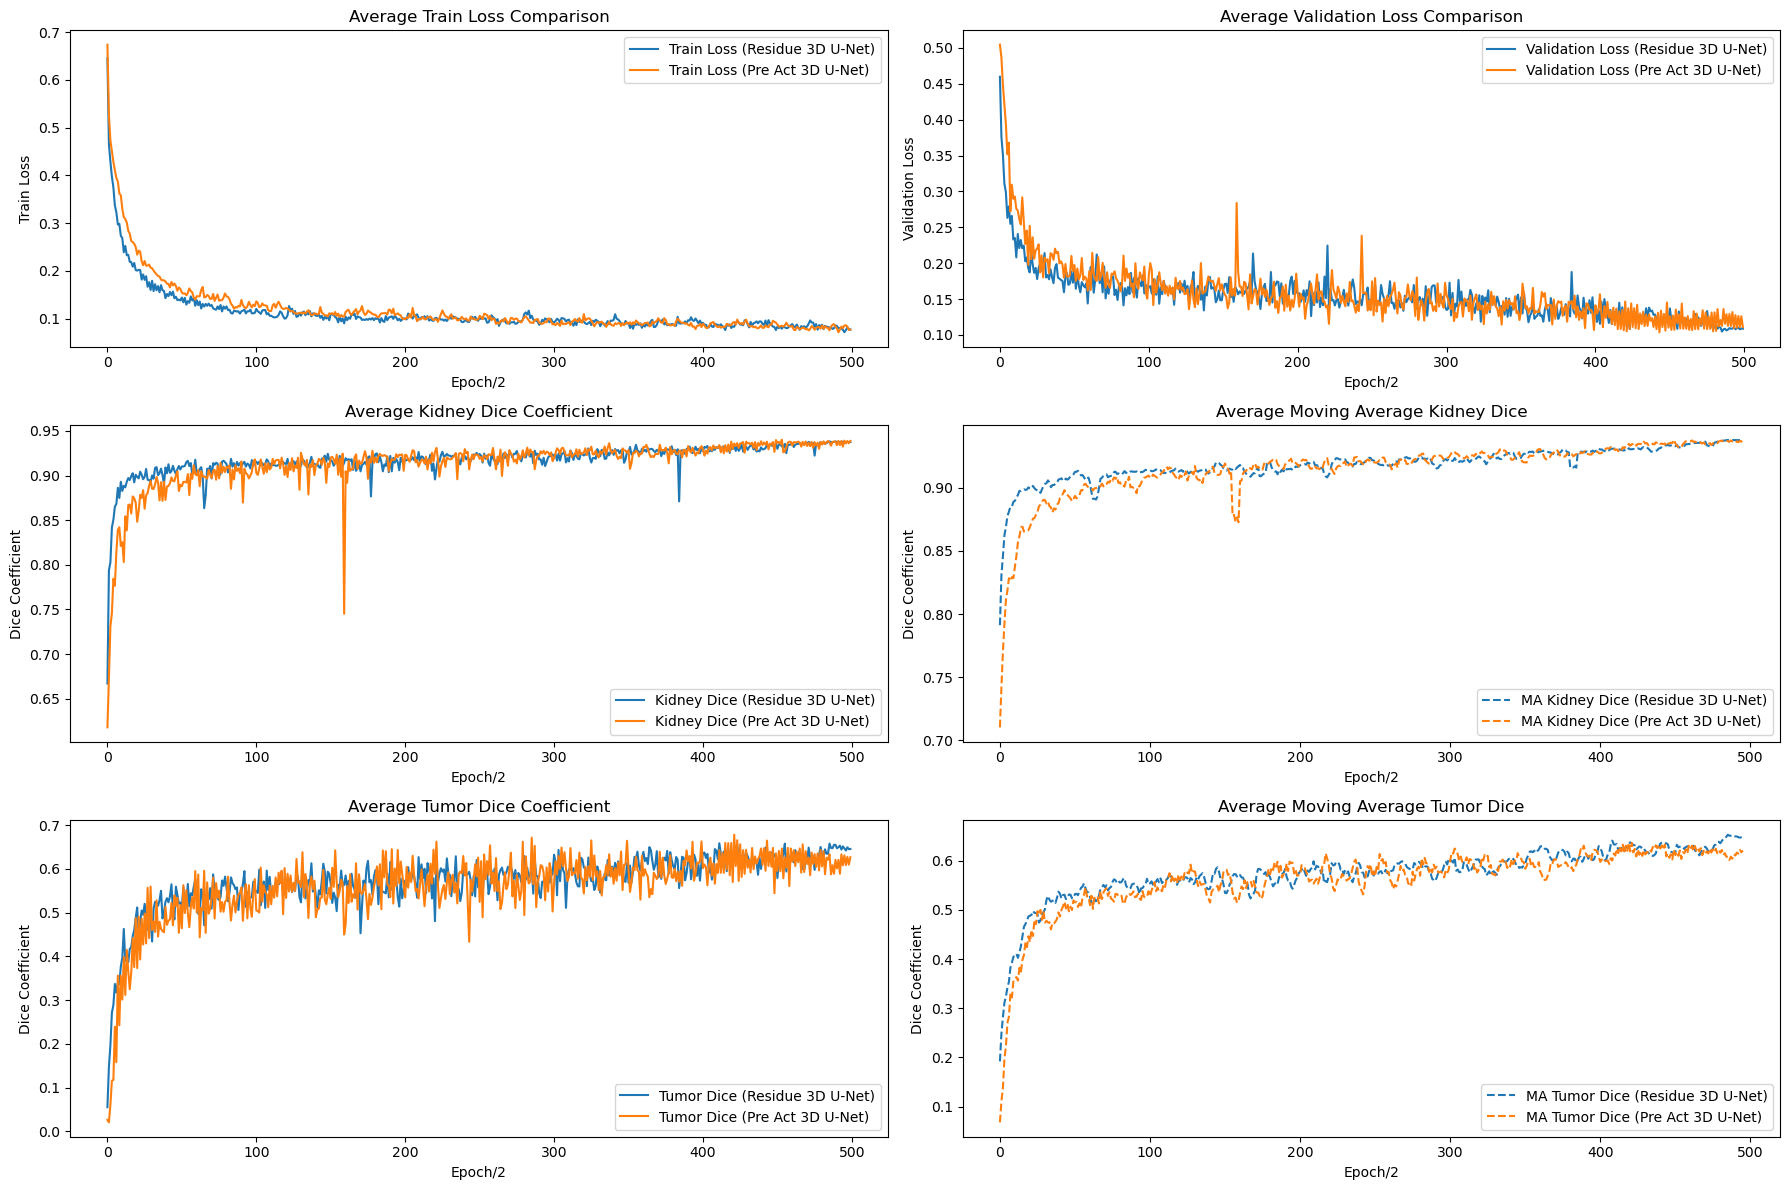

In [32]:
plot_average_training_logs(
    log_path_pattern_1='residual_unet_3d_fold{i}_epochs1000/training_logs.json',
    log_path_pattern_2='pre_act_unet_3d_fold{i}_epochs1000/training_logs.json',
    label=['Residue 3D U-Net', 'Pre Act 3D U-Net'],
    figure_name='plots/residue_preact_average_training_comparison.png',
    epochs=500
)

### Residue ($\eta=0.05$ or $\eta=0.03$)

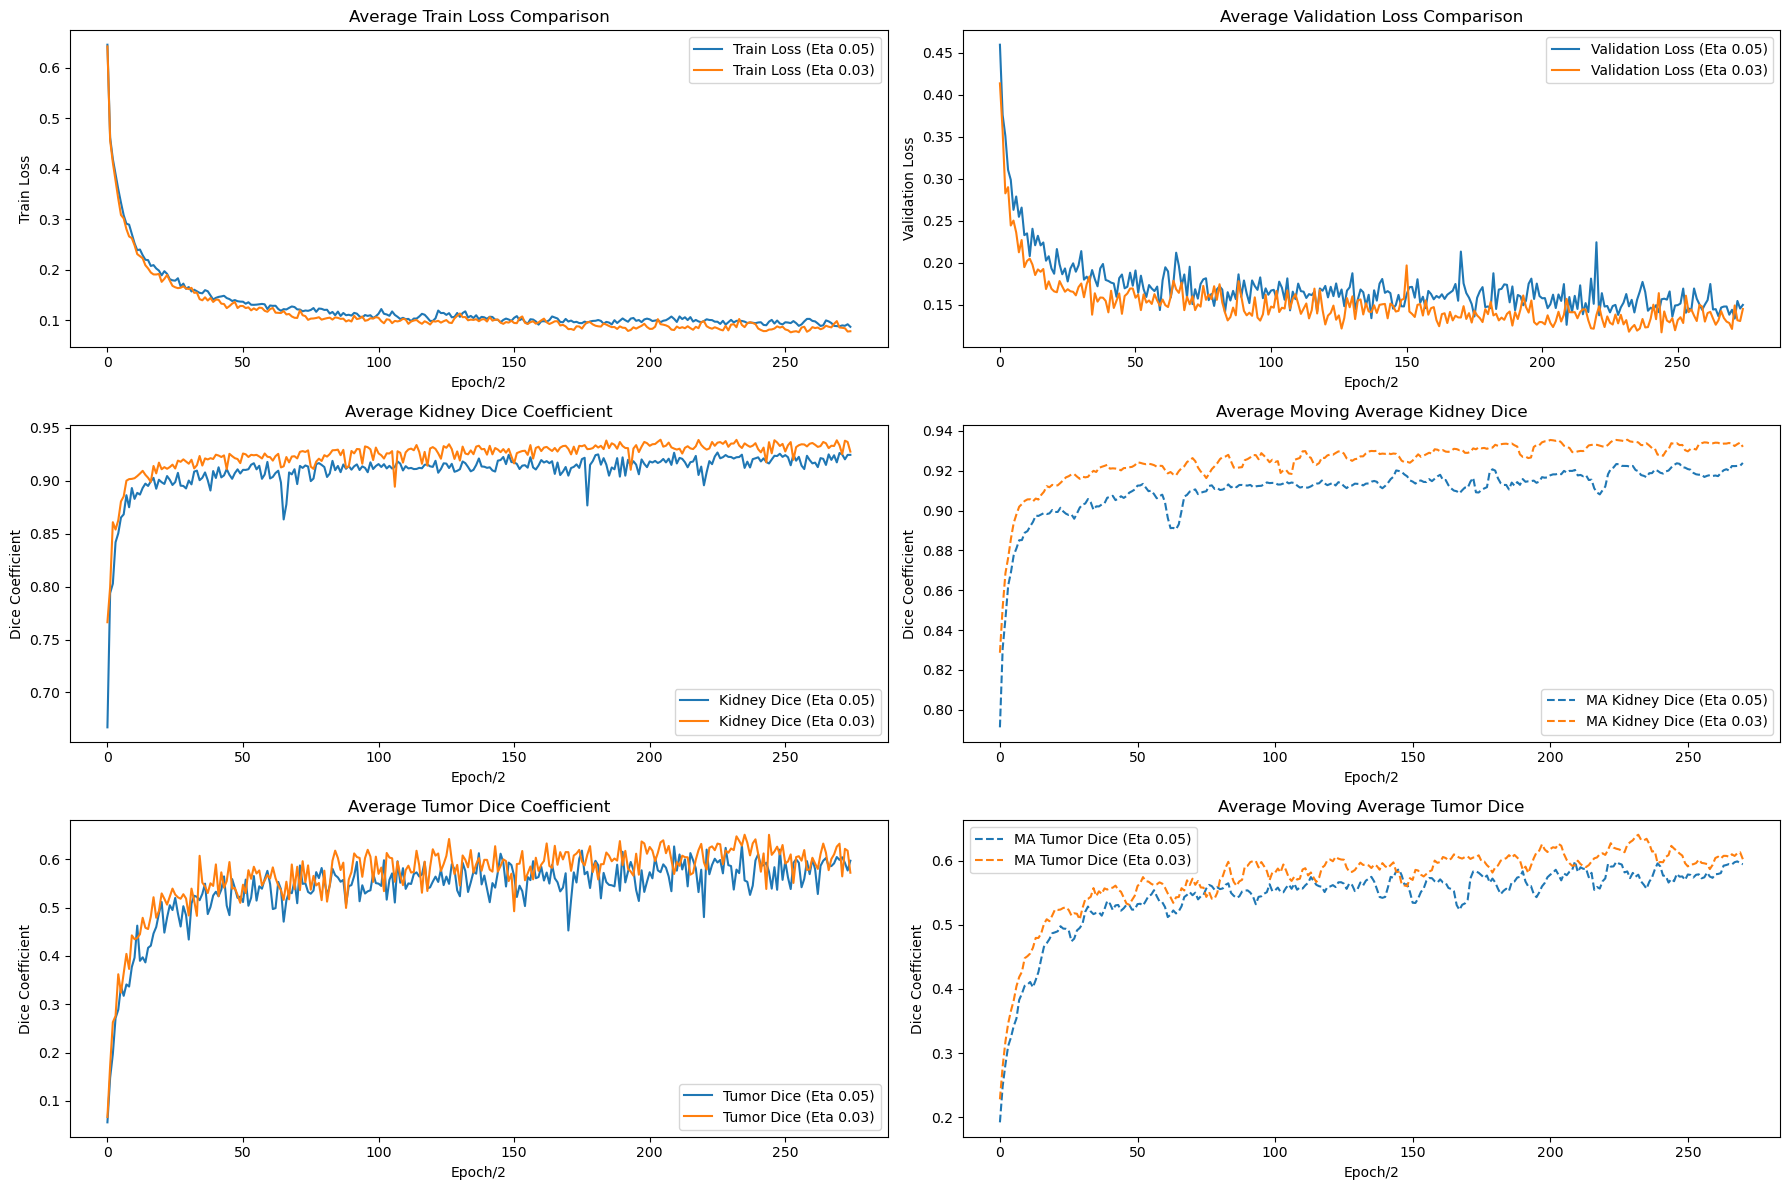

In [29]:
plot_average_training_logs(
    log_path_pattern_1='residual_unet_3d_fold{i}_epochs1000/training_logs.json',
    log_path_pattern_2='residual_unet_3d_fold{i}_epochs500_0.03/training_logs.json',
    label=['Eta 0.05', 'Eta 0.03'],
    figure_name='plots/residue_different_learning_rate_comparison.png',
    epochs=275
)